In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from itertools import cycle
import matplotlib.style as style
from collections import Counter
style.use('seaborn')

colors = cycle(["C{}".format(i) for i in range(10)])

In [135]:
import functions as f

stations = pd.read_csv("stations.csv")
lats = list(stations.get('latitude'))
longs = list(stations.get('longitude'))

names = []
towns = []
points = []
for index, row in stations.iterrows():
    names.append( row['name'] )
    towns.append( row["town"] )
    lat = lats[index]
    long = longs[index]
    points.append( (lat, long) )

In [136]:
import functions as f
import datetime

trips = pd.read_csv("trips2.csv")

trips["start_time"] = pd.to_datetime(trips["start_time"])
trips["duration"] = pd.to_timedelta(trips["duration"])
deltaF = datetime.timedelta(minutes=1) # filter out trips which take less than 1 min
deltaC = datetime.timedelta(hours=24) # filter out trips which take longer than a day
trips = trips.loc[trips['duration'] > deltaF]
trips = trips.loc[trips['duration'] < deltaC]

timeRange = trips["start_time"].to_list()

display(trips)

,Unnamed: 0,id,start_station,start_city,end_station,end_city,start_time,duration
0,0,route_10_2020@a2a17c30-d848-4ded-94f0-bd8ae05a...,Main Street-Bridge Street,Northampton,Florence Center,Northampton,2020-10-06 12:37:36+00:00,0 days 00:17:25
1,1,route_10_2020@5b2f37e6-e06a-43ae-949e-b2ffd2de...,Village Hill-State Hospital,Northampton,Village Hill-State Hospital,Northampton,2020-10-06 12:42:02+00:00,0 days 00:41:35
2,2,route_10_2020@c74f25cd-e0c6-4fe7-9a2f-7e31324f...,Florence Center,Northampton,Florence Center,Northampton,2020-10-06 12:44:47+00:00,0 days 00:49:40
3,3,route_10_2020@ff5d4317-b149-42a4-bc5e-9bc101da...,YMCA-Childs Park,Northampton,John M Greene Hall-Smith College,Northampton,2020-10-06 12:49:30+00:00,0 days 00:06:00
4,4,route_10_2020@2b54f8e3-ed53-48ab-b065-43d59144...,Jackson Street,Northampton,State St-Mass Central Rail Trail,Northampton,2020-10-06 12:58:39+00:00,0 days 00:24:25
...,...,...,...,...,...,...,...,...
166283,166283,route_06_2022@9f9c149d-b8af-4d43-8882-5b6d7cb9...,Amherst Town Hall,Amherst,University Drive,Amherst,2022-06-07 02:20:55+00:00,0 days 00:07:00
166284,166284,route_06_2022@aa343271-8410-440e-9329-f8fa76ad...,University Drive,Amherst,University Drive,Amherst,2022-06-07 02:29:10+00:00,0 days 00:10:00
166285,166285,route_06_2022@42643acc-7592-4aa7-aff1-b667a2e3...,Mackenzie Field,Holyoke,Holyoke Medical Center Station,Holyoke,2022-06-07 02:34:58+00:00,0 days 00:07:45
166286,166286,route_06_2022@39cbaf9d-d9eb-460c-8f4d-f16ea151...,El Corazon,Holyoke,South Holyoke,Holyoke,2022-06-07 02:47:24+00:00,0 days 00:28:00


In [137]:
from datetime import date

def rem_time(d):
    s = date(d.year,d.month, d.day)
    return s

def plot_daily_num_trips(trips, townname="started in all towns", color='k'):
    trips.sort_values(by='start_time')
    dateTrip = {}

    for index, row in trips.iterrows():
        day = rem_time(row['start_time'])
        if day not in dateTrip.keys():
            dateTrip[day] = 1
        else:
            dateTrip[day] += 1

    dates = list(dateTrip.keys())
    numTrips = list(dateTrip.values())
    plt.figure(figsize=(8,3), dpi=150)
    plt.plot(dates, numTrips, color=color)
    plt.title("Trips {} over time".format(townname))
    plt.ylabel('number of trips'.format(townname))
    plt.xlabel("Date")
    plt.xlim(timeRange[0], timeRange[-1])
    plt.tight_layout()
    path = "./plots/num_trips.png"
    if townname != "started in all towns":
        path = "./plots/by_city/{}_trips.png".format(townname)
    plt.savefig(path, facecolor='w')
    plt.clf()

def plot_daily_num_trips_bar(trips, stationname="started at all stations", color='k'):
    trips.sort_values(by='start_time')
    dateTrip = {}

    for index, row in trips.iterrows():
        day = rem_time(row['start_time'])
        if day not in dateTrip.keys():
            dateTrip[day] = 1
        else:
            dateTrip[day] += 1

    dates = list(dateTrip.keys())
    numTrips = list(dateTrip.values())
    plt.figure(figsize=(8,3), dpi=150)
    plt.bar(dates, numTrips, color=color)
    plt.title("Trips {} station over time".format(stationname))
    plt.ylabel('number of trips'.format(stationname))
    plt.xlabel("Date")
    plt.xlim(timeRange[0], timeRange[-1])
    plt.tight_layout()
    path = "./plots/num_trips_bar.png"
    if stationname != "started at all stations":
        path = "./plots/by_station/{} trips.png".format(stationname)
    plt.savefig(path, facecolor='w')
    plt.clf()

def plot_dist_durations(trips, townname="all towns"):
    durations = [x.total_seconds() for x in trips['duration']]
    print(min(durations))
    print(max(durations))
    plt.figure(figsize=(7,3), dpi=150)
    stat = "proportion"  # or proportion
    sns.histplot(durations, stat=stat, cumulative=True, alpha=.4)
    sns.ecdfplot(durations, stat=stat)
    plt.xlim(0, 20000)
    plt.title("Cumulative Distribution of Trip Durations in {}".format(townname))
    plt.ylabel("Probability")
    plt.xlabel("Trip Duration in Seconds")
    path = "./plots/durations.png"
    if townname != "all towns":
        path = "./plots/by_city/durations_{}.png".format(townname)
    plt.savefig(path, facecolor='w')
    plt.clf()

# plot_dist_durations(trips)

In [138]:
plot_daily_num_trips(trips)

<Figure size 1200x450 with 0 Axes>

In [ ]:
towns = set(towns)
for town in towns:
    towntrips = trips.loc[trips['start_city'].str.contains(town)]
    print("Daily Trips starting in {}".format(town))
    plot_daily_num_trips(towntrips, townname="starting in "+town, color=next(colors))

for town in towns:
    towntrips = trips.loc[trips['end_city'].str.contains(town)]
    print("Daily Trips ending in {}".format(town))
    plot_daily_num_trips(towntrips, townname="ending in "+town, color=next(colors))

Daily Trips starting in West Springfield
Daily Trips starting in South Hadley
Daily Trips starting in Easthampton
Daily Trips starting in Holyoke
Daily Trips starting in Northampton
Daily Trips starting in Chicopee
Daily Trips starting in Springfield
Daily Trips starting in Amherst
Daily Trips ending in West Springfield
Daily Trips ending in South Hadley
Daily Trips ending in Easthampton
Daily Trips ending in Holyoke
Daily Trips ending in Northampton
Daily Trips ending in Chicopee
Daily Trips ending in Springfield
Daily Trips ending in Amherst


<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

<Figure size 1200x450 with 0 Axes>

In [ ]:
difftrips = trips.loc[trips['start_city'] != trips['end_city']]
display(difftrips)

,Unnamed: 0,id,start_station,start_city,end_station,end_city,start_time,duration
6,6,route_10_2020@8aca36ae-cd76-4ff4-99ae-439478a8...,The Pedlar Station-Crosier Field,Holyoke,Northampton Train Station,Northampton,2020-10-06 13:11:02+00:00,0 days 00:46:10
12,12,route_10_2020@6f120d89-d155-4fe1-aed5-1b109e26...,Northampton Train Station,Northampton,Rail Trail @ Union Street,Easthampton,2020-10-06 14:52:04+00:00,0 days 00:21:00
13,13,route_10_2020@703757ec-c807-4196-9eb8-059b7474...,Northampton Train Station,Northampton,Rail Trail @ Union Street,Easthampton,2020-10-06 15:37:00+00:00,0 days 00:26:05
15,15,route_10_2020@62a6ecf8-0d2b-4ff9-8ec8-64fddd27...,Rail Trail @ Union Street,Easthampton,Northampton Train Station,Northampton,2020-10-06 15:41:19+00:00,0 days 00:19:30
57,57,route_10_2020@07c90dcf-5964-40bd-8c5a-1f9d6549...,Main Street-Bridge Street,Northampton,University Drive,Amherst,2020-10-06 18:45:19+00:00,0 days 00:39:50
...,...,...,...,...,...,...,...,...
166180,166180,route_06_2022@5fb049b0-c1aa-4eed-9b25-80ba1ac9...,Rail Trail @ Millside Park,Easthampton,Mackenzie Field,Holyoke,2022-06-06 22:51:23+00:00,0 days 00:45:50
166182,166182,route_06_2022@9d709cf6-d301-43f2-b5a8-4fe3024e...,Rail Trail @ Millside Park,Easthampton,Mackenzie Field,Holyoke,2022-06-06 22:51:53+00:00,0 days 00:45:20
166206,166206,route_06_2022@79c875ca-debd-4aa9-ad38-9d4d7542...,West Springfield Memorial Avenue,West Springfield,Baystate Health-Main Street,Springfield,2022-06-06 23:29:46+00:00,0 days 00:23:45
166232,166232,route_06_2022@58db5eb2-02b7-4006-b34b-aa187306...,Live Well Springfield Station,Springfield,Chicopee City Hall,Chicopee,2022-06-07 00:10:30+00:00,0 days 00:23:55


In [ ]:
11315.0/142340.0

0.07949276380497401

Daily Trips starting in one city, ending in another


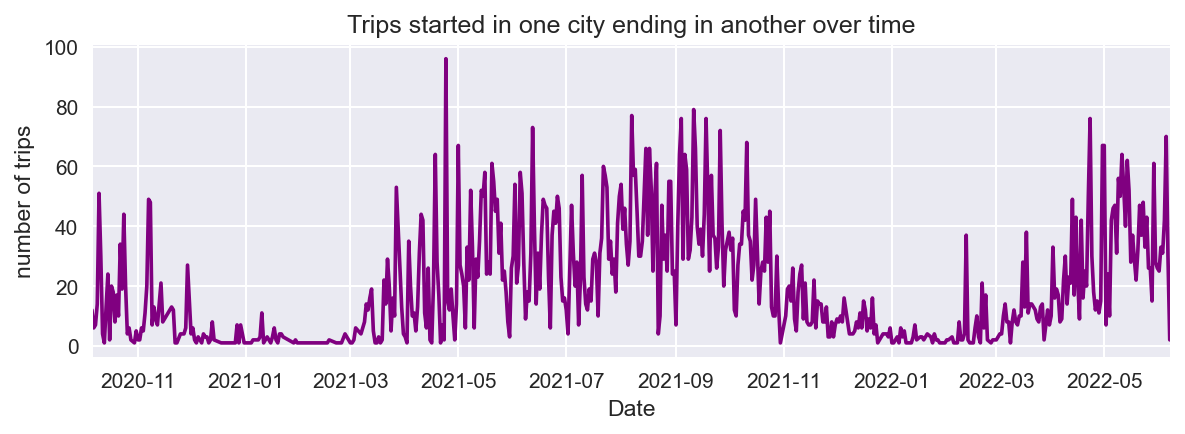

In [ ]:
print("Daily Trips starting in one city, ending in another")
plot_daily_num_trips(difftrips, townname="one city ending in another", color='purple')

In [141]:
for stationname in names:
    stattrips = trips.loc[trips['start_station'].str.contains(stationname)]
    print("Daily Trips starting at {}".format(stationname))
    plot_daily_num_trips_bar(stattrips, stationname="starting at "+stationname, color=next(colors))
    
for stationname in names:
    stattrips = trips.loc[trips['end_station'].str.contains(stationname)]
    print("Daily Trips ending at {}".format(stationname))
    plot_daily_num_trips_bar(stattrips, stationname="ending at "+stationname, color=next(colors))

# plot_daily_num_trips_bar(umtrips, stationname="UMass Haigis Mall", color='magenta')
# plot_daily_num_trips_bar(sptrips, stationname="Springfield Armory", color='blue')
# plot_daily_num_trips_bar(ehtrips, stationname="Easthampton City Hall", color='red')

Daily Trips starting at North Pleasant Street
Daily Trips starting at UMass Sylvan Residential Area
Daily Trips starting at UMass Knowlton
Daily Trips starting at UMass ILC
Daily Trips starting at UMass Central Residential Area
Daily Trips starting at UMass Haigis Mall
Daily Trips starting at UMass Southwest
Daily Trips starting at Kendrick Park
Daily Trips starting at Amherst Town Hall
Daily Trips starting at South East Street
Daily Trips starting at University Drive
Daily Trips starting at East Hadley Road
Daily Trips starting at Mount Holyoke College Station
Daily Trips starting at Woodlawn Plaza
Daily Trips starting at Eink Station
Daily Trips starting at Rivers Park
Daily Trips starting at Chicopee Falls
Daily Trips starting at Chicopee City Hall
Daily Trips starting at Baystate Health-Main Street
Daily Trips starting at Baystate Health-Chestnut Street
Daily Trips starting at Kenefick Park


/var/folders/0k/kp1z5hs92qs430gh81z0m3g00000gn/T/ipykernel_55870/3871177132.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,3), dpi=150)


Daily Trips starting at Live Well Springfield Station
Daily Trips starting at American International College
Daily Trips starting at Mason Square Library
Daily Trips starting at STCC - Springfield Armory
Daily Trips starting at Mercy Medical Center Station
Daily Trips starting at CFWM @ Stearns Square Station
Daily Trips starting at Pynchon Park-Museums
Daily Trips starting at Court Square
Daily Trips starting at MGM Springfield
Daily Trips starting at South End-Main Street
Daily Trips starting at Basketball Hall of Fame
Daily Trips starting at West Springfield Memorial Avenue
Daily Trips starting at West Springfield Library
Daily Trips starting at Springdale Park
Daily Trips starting at The Pedlar Station-Crosier Field
Daily Trips starting at South Holyoke
Daily Trips starting at Holyoke Community College
Daily Trips starting at Mackenzie Field
Daily Trips starting at El Corazon
Daily Trips starting at Depot Square
Daily Trips starting at Ely Court
Daily Trips starting at Holyoke Medi

Distribution of durations in West Springfield
65.0
85727.0
Distribution of durations in South Hadley
65.0
70180.0
Distribution of durations in Easthampton
65.0
83516.0
Distribution of durations in Holyoke
61.0
84743.912
Distribution of durations in Northampton
63.0
85261.0
Distribution of durations in Chicopee
61.578
36625.0
Distribution of durations in Springfield
64.0
86075.0
Distribution of durations in Amherst
62.0
85570.0


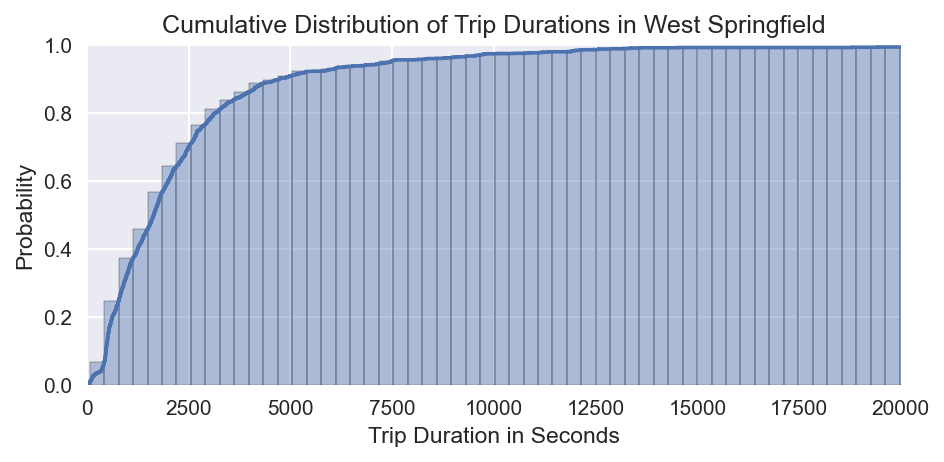

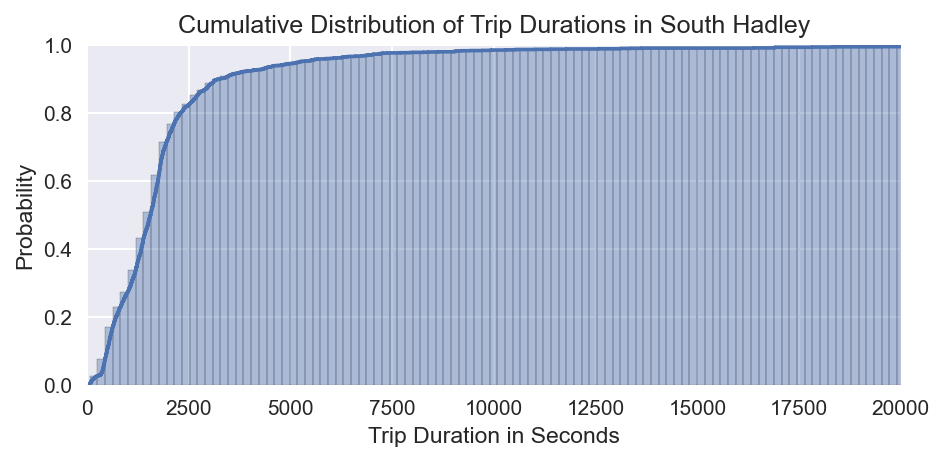

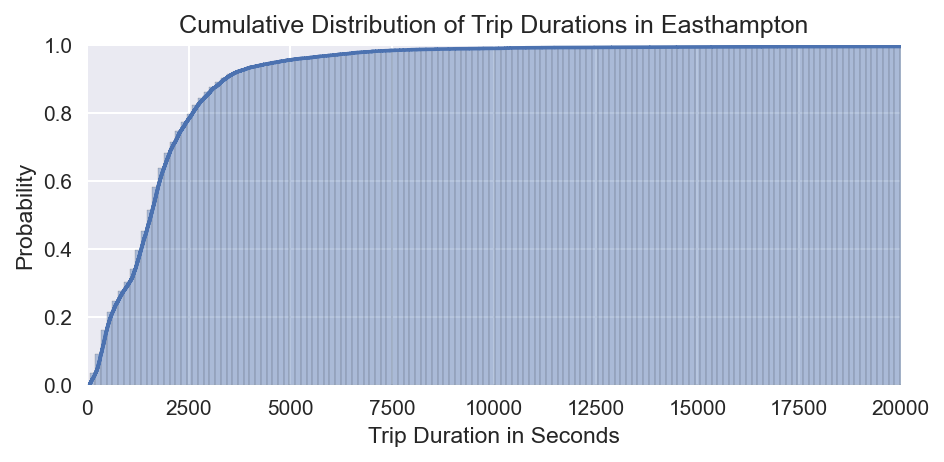

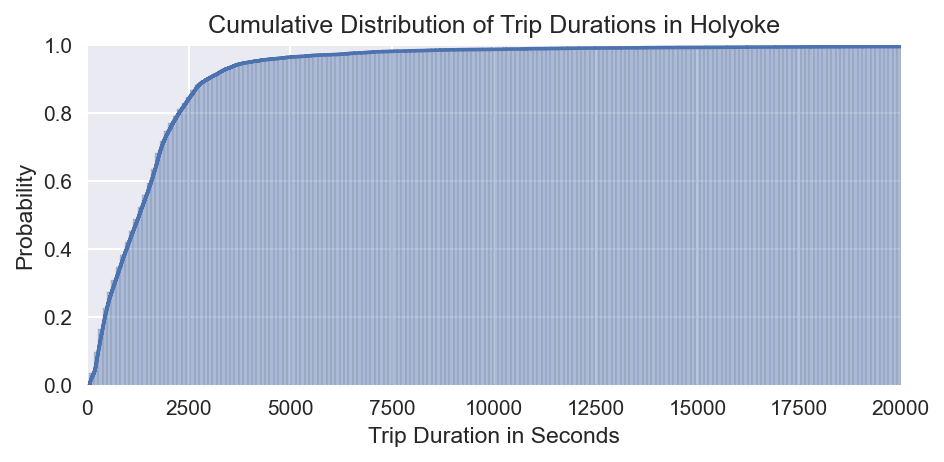

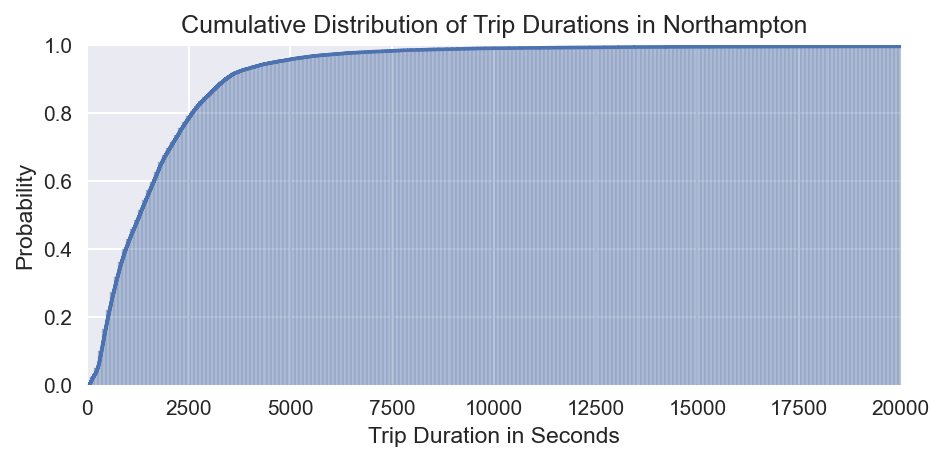

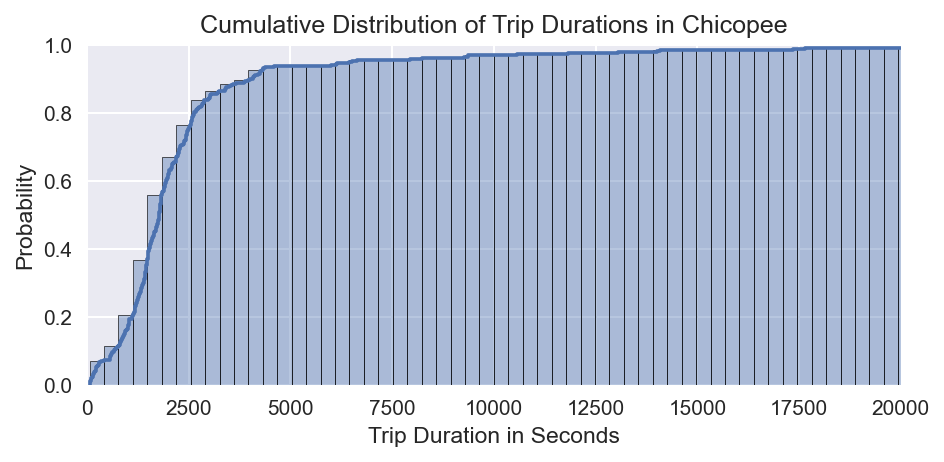

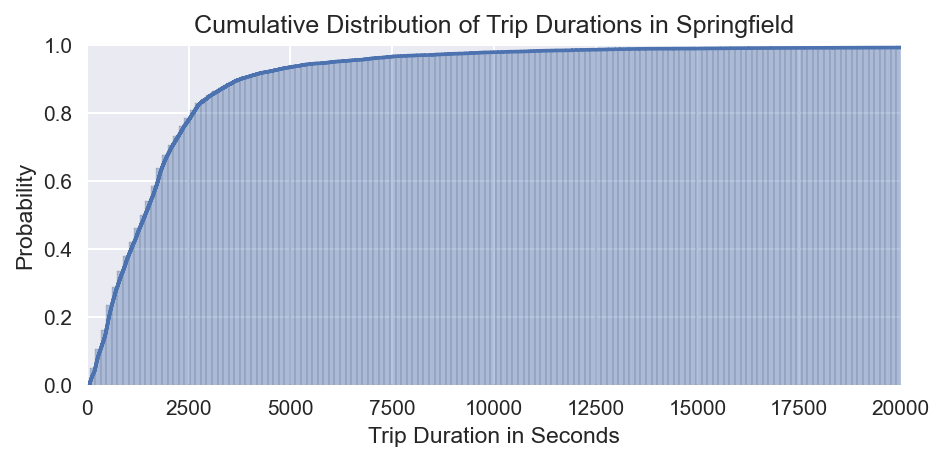

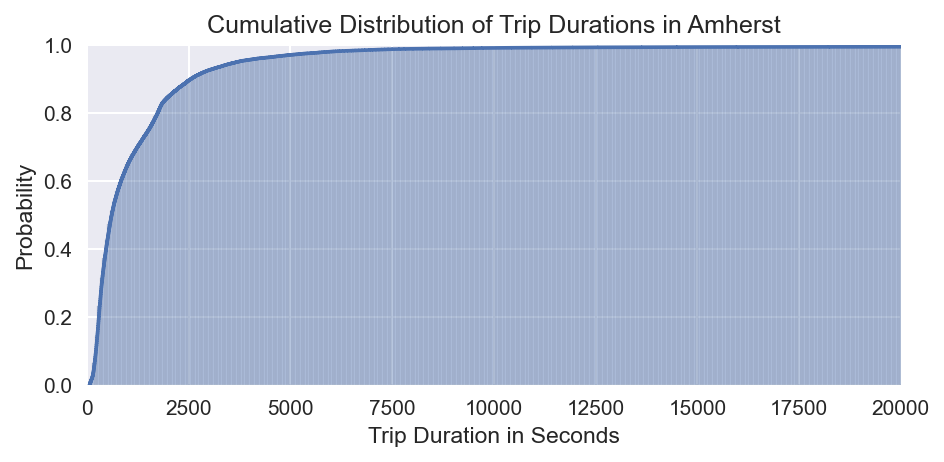

In [52]:
for town in towns:
    towntrips = trips.loc[trips['start_city'].str.contains(town)]
    print("Distribution of durations in {}".format(town))
    plot_dist_durations(towntrips, townname=town)

(70, 70)


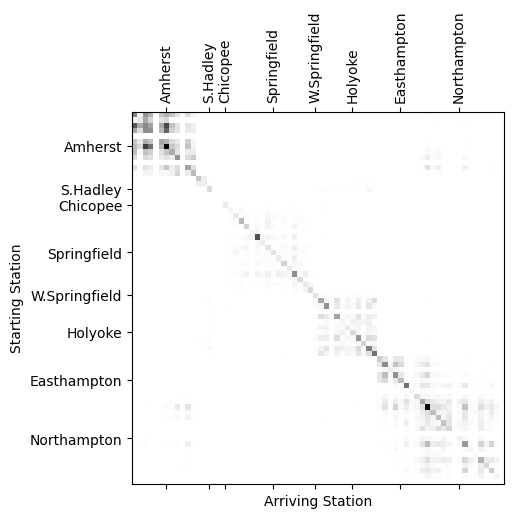

In [116]:

# def plot_dist_trip_tuples(trips, townname="all towns"):
size = len(names)
style.use('default')

startAndEnd = list(zip(trips['start_station'], trips['end_station']))
result = Counter(startAndEnd)

matrix = np.zeros([size, size])

for fromStation in names:
    for toStation in names:
        count = result[(fromStation, toStation)]
        matrix[names.index(fromStation), names.index(toStation)] = count

print(matrix.shape)
plt.matshow(matrix, cmap='binary')
plt.ylabel("Starting Station")
plt.xlabel("Arriving Station")
ticks = [0, 13, 16, 19, 33, 35, 48, 52, 70]
avgticks = [int((ticks[i]+ticks[i+1])/2) for i in range(len(ticks)-1)]
labels = ["Amherst", "S.Hadley", "Chicopee", "Springfield", "W.Springfield", "Holyoke", "Easthampton", "Northampton"]
plt.xticks(avgticks, labels=labels, rotation=90)
plt.yticks(avgticks, labels=labels)
plt.show()

# plot_dist_durations(trips)

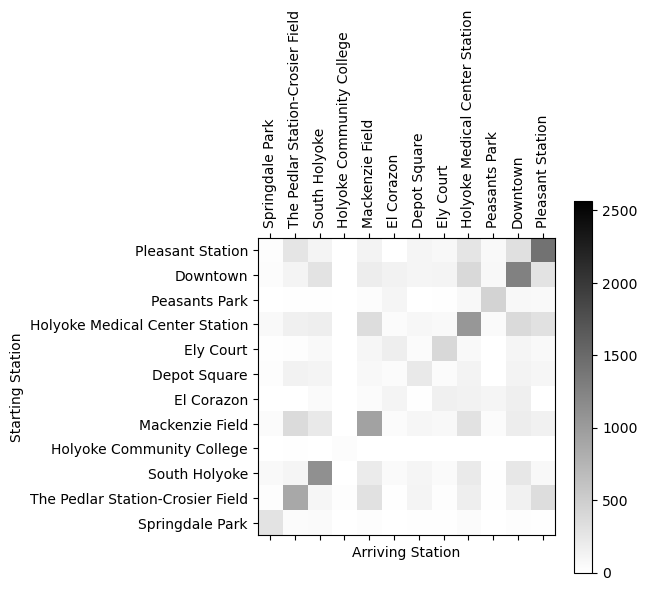

In [133]:
# def plot_dist_trip_tuples(trips, townname="all towns"):
size = len(names)
style.use('default')

startAndEnd = list(zip(trips['start_station'], trips['end_station']))
result = Counter(startAndEnd)

matrix = np.zeros([size, size])

for fromStation in names:
    for toStation in names:
        count = result[(fromStation, toStation)]
        matrix[names.index(fromStation), names.index(toStation)] = count

matrix[~(matrix==0).all(1)]

plt.matshow(matrix, cmap='binary')
plt.ylabel("Starting Station")
plt.xlabel("Arriving Station")

ticks = range(34,46)
labels = [names[i] for i in range(34,46)]
plt.xlim(33.5, 45.5)
plt.ylim(33.5, 45.5)
plt.xticks(ticks, labels=labels, rotation=90)
plt.yticks(ticks, labels=labels)
plt.colorbar()
plt.show()

# plot_dist_durations(trips)